In [16]:
# %load main.py
"""
FireWorks implementation for the computation of electronic structure for
molecules in the Metatlas database.

-----------    ----------    -----------
| Create  |    | Run    |    | Process |
| Orca    | => | Orca   | => | Output  |
| Input   |    | Calc   |    | File    |
-----------    ----------    -----------
"""
import pprint
from configparser import ConfigParser
from fireworks import Firework, LaunchPad, Workflow, FWorker
from fireworks.user_objects.queue_adapters.common_adapter import CommonAdapter
from fireworks.user_objects.metatlas import ComputeEnergyTask, AddCalculationtoDBTask
from fireworks.queue.queue_launcher import launch_rocket_to_queue
from metatlas import read_molecules_from_csv, create_pybel_molecule, create_orca_input_string
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def create_launchpad(db_config_file):
    """use to create a FW launchpad using mongodb creds from file"""
    config = ConfigParser()
    with open(db_config_file) as f:
        config.read_file(f)
    db = config['db']

    lpad = LaunchPad(
        host=db['host'],
        port=int(db['port']),
        name=db['name'],
        username=db['username'],
        password=db['password'])

    return lpad


def create_fworker(name):
    fworker_config = '/home/bkrull/.fireworks/' + name.lower() + '.yaml'
    fworker = FWorker().from_file(fworker_config)

    return fworker


def create_queue_adapater(q_type):
    slurm_adapter = CommonAdapter(
        q_type=q_type,
        template_file='/home/bkrull/.fireworks/slurm.yaml',
        reserve=True)

    return slurm_adapter


METATLAS_DB_CONFIG = '/home/bkrull/.fireworks/metatlas.ini'
CSV_FILE = 'metatlas_inchi_inchikey.csv'
PROJECT_HOME = 'scr/'

metatlas_lpad = create_launchpad(METATLAS_DB_CONFIG)

## Find completed but not processed
These fw_ids have already been updated to have 'AddCalculationtoDBTask' in their structure,
not quite sure because they're not in the 'READY' state to be run..

In [30]:
query = {
    'action.additions.0': {
        '$exists':'true'
    }
}

completed_not_processed = metatlas_lpad.get_fw_ids(query, launches_mode=True)
fw = metatlas_lpad.get_fw_by_id(completed_not_processed[0]).as_dict()

query = {
    'action.additions.0': {
        '$exists':'true'
    },
    'launch_dir': {
        '$exists': 'true'
    }
}
completed_not_processed_with_ldir = metatlas_lpad.get_fw_ids(query, launches_mode=True)

print 'Number of AddtoDBTasks: {}'.format(len(completed_not_processed))
print 'Number of AddtoDBTasks with launchdirs: {}'.format(len(completed_not_processed_with_ldir))
pprint.pprint(fw)

Number of AddtoDBTasks: 21459
Number of AddtoDBTasks with launchdirs: 21459
{'created_on': '2017-05-04T17:14:36.949575',
 'fw_id': 1,
 'launches': [{'action': {'additions': [{'created_on': '2017-05-04T17:35:41.208063',
                                         'fws': [{'created_on': '2017-05-04T17:35:41.208063',
                                                  'fw_id': -1,
                                                  'name': 'Unnamed FW',
                                                  'spec': {'_tasks': [{'_fw_name': 'fireworks::AddCalculationtoDBTask',
                                                                       'path_to_calc_output': 'C44H76NO8P.out'}]},
                                                  'updated_on': '2017-05-04T17:35:41.208073'}],
                                         'links': {'-1': []},
                                         'metadata': {},
                                         'name': 'Unnamed FW',
                                       

## Find completed that have optimized coordinates added

In [34]:
query = {
    'action.stored_data.optimized_coords': {
        '$exists': 'true'
    }
}

completed_with_coords = metatlas_lpad.get_fw_ids(query, launches_mode=True)
fw = metatlas_lpad.get_fw_by_id(completed_with_coords[-1]).as_dict()

query = {
    'action.stored_data.optimized_coords': {
        '$exists': 'true'
    },
    'launch_dir': {
        '$exists': 'true'
    }
}

completed_with_coords_with_ldir = metatlas_lpad.get_fw_ids(query, launches_mode=True)

print 'Number of Completed with coords: {}'.format(len(completed_with_coords))
print 'Number of Completed with coords with launch_dir: {}'.format(len(completed_with_coords_with_ldir))

pprint.pprint(fw)

Number of Completed with coords: 3944
Number of Completed with coords with launch_dir: 3944
{'created_on': '2017-05-04T21:32:18.491656',
 'fw_id': 29400,
 'launches': [{'action': {'additions': [],
                          'defuse_children': False,
                          'defuse_workflow': False,
                          'detours': [],
                          'exit': False,
                          'mod_spec': [],
                          'stored_data': {'energy': {'units': 'Hartree',
                                                     'value': '-133.066555748950'},
                                          'optimized_coords': '49\nCoordinates from ORCA-job C17H28O4 E -133.066555748950\n  C       0.962311     -9.724499      4.653908\n  C       4.093382     -6.656971      0.377458\n  C      -2.791887     -6.255518      1.306186\n  C      -0.241922     -5.414046     -0.831854\n  C      -2.311900     -7.963228      3.605724\n  C      -1.278856     -8.719554      4.368882\n  C    

## Find fizzled

In [32]:
query = {
    'state': 'FIZZLED'
}

fizzled = metatlas_lpad.get_fw_ids(query, launches_mode=True)
fw = metatlas_lpad.get_fw_by_id(fizzled[0]).as_dict()

query = {
    'state': 'FIZZLED',
    'launch_dir': {
        '$exists': 'true'
    }
}

fizzled_with_ldir = metatlas_lpad.get_fw_ids(query, launches_mode=True)

print 'Number of fizzled jobs: {}'.format(len(fizzled))
print 'Number of fizzled jobs with launch dir: {}'.format(len(fizzled_with_ldir))
pprint.pprint(fw)

Number of fizzled jobs: 2487
Number of fizzled jobs with launch dir: 2487
{'created_on': '2017-05-04T17:18:49.138703',
 'fw_id': 460,
 'launches': [{'action': None,
               'fw_id': 460,
               'fworker': {'category': '',
                           'env': {},
                           'name': 'edison',
                           'query': '{}'},
               'host': 'nid06101',
               'ip': '10.128.24.6',
               'launch_dir': '/global/u2/b/bkrull/apps/MetAtlas/calcs/block_2017-05-04-18-30-00-929389/launcher_2017-05-04-18-35-49-574657',
               'launch_id': 433,
               'state': 'FIZZLED',
               'state_history': [{'created_on': '2017-05-04T18:37:16.379509',
                                  'state': 'RUNNING',
                                  'updated_on': '2017-05-04T21:37:16.415062'},
                                 {'created_on': '2017-06-28T15:38:21.709508',
                                  'state': 'FIZZLED'}],
            

## Launched statistics

Total number of launched jobs: 28393
Number of fizzled jobs: 2487
Number of Completed with coords: 3944
Number of AddtoDBTasks: 21459
Unaccounted launches: 503


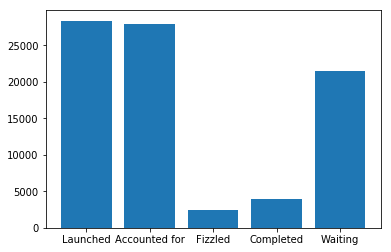

In [33]:
query = {}

total_launched = metatlas_lpad.get_fw_ids(query, launches_mode=True)
total_status_jobs = len(completed_and_processed) + \
                    len(completed_with_coords) + len(fizzled)
    
plt.bar([0, 1, 2, 3, 4], 
        [len(total_launched), total_status_jobs, len(fizzled), 
         len(completed_with_coords), len(completed_not_processed)],
       tick_label=['Launched', 'Accounted for', 'Fizzled', 'Completed', 'Waiting'])

print 'Total number of launched jobs: {}'.format(len(total_launched))
print 'Number of fizzled jobs: {}'.format(len(fizzled))
print 'Number of Completed with coords: {}'.format(len(completed_with_coords))
print 'Number of AddtoDBTasks: {}'.format(len(completed_not_processed))
print 'Unaccounted launches: {}'.format(len(total_launched) - total_status_jobs)

## Figure out method for running a local parse of completed but not processed calcs

In [ ]:
def get_and_update_outputfile_dir(fw_id):
    fw = lpad.get_fw_dict_by_id(fw_id)
    time_created = lpad.get_fw_dict_by_id(fw_id)['created_on']
    time_created = datetime.datetime.strptime(time_created,'%Y-%m-%dT%H:%M:%S.%f')
    output_file = fw['spec']['_tasks'][0]['path_to_calc_output']
    mol = output_file.split('.')[0]
    
    calc_db_id = lpad.get_fw_ids({'state': 'COMPLETED', 
                                  'spec._tasks._fw_name': 'ComputeEnergyTask', 
                                  'name': mol})[-1]
#    for i in calc_db_id:
#        try:
#            calc = lpad.get_fw_dict_by_id(i)
#        except:
#            pass
#        else:
#            calc_time = calc['launches'][0]['time_end']
#            calc_time = datetime.datetime.strptime(calc_time,'%Y-%m-%dT%H:%M:%S.%f')
#            print time_created - calc_time
        
    calc_dir = lpad.get_fw_dict_by_id(calc_db_id)['launches'][0]['launch_dir']
    new_path_to_output = calc_dir+'/'+output_file
    
    print new_path_to_output
    lpad.update_spec([fw_id], 
                    {'_tasks': [{'_fw_name': 'fireworks::AddCalculationtoDBTask', 
                                'path_to_calc_output': new_path_to_output}]})
    # parse molecule name from

In [40]:
mol = 'C44H76NO8P'
fw = Firework(AddCalculationtoDBTask(input_file=mol+'.out'),
        name=mol)
wf = Workflow([fw])
lpad.append_wf(wf, [179950, 179949])

In [69]:
def make_xyz(atoms):
    xyz = []
    natoms = str(len(atoms))
    
    xyz.append(natoms+'\n\n')
    
    for atom in atoms:
        line = atom['elementSymbol'] + '\t'
        line += '\t'.join(atom['cartesianCoordinates']['value'])
        
        xyz.append(line)
    print xyz

In [87]:
with open('C10H14N5O7P.trj', 'r') as f:
    content = f.readlines()

In [88]:
type(content)

list

In [6]:
lpad.rerun_fws_task_level(1, recover_mode='prev_dir')
lpad.get_fw_dict_by_id(1)

2017-06-28 15:08:03,990 INFO No information to recover launch id 1 for m_fw 1. Skipping...


{u'_id': ObjectId('590b617cd95cbb63a650309a'),
 u'archived_launches': [],
 u'created_on': u'2017-05-04T17:14:36.949575',
 u'fw_id': 1,
 u'launches': [{u'_id': ObjectId('590b61bfd95cbb63a6503112'),
   u'action': {u'additions': [{u'created_on': u'2017-05-04T17:35:41.208063',
      u'fw_id': -1,
      u'name': u'Unnamed FW',
      u'spec': {u'_tasks': [{u'_fw_name': u'fireworks::AddCalculationtoDBTask',
         u'path_to_calc_output': u'C44H76NO8P.out'}]},
      u'updated_on': u'2017-05-04T17:35:41.208073'}],
    u'defuse_children': False,
    u'defuse_workflow': False,
    u'detours': [],
    u'exit': False,
    u'mod_spec': [],
    u'stored_data': {u'path_to_calc_output': u'C44H76NO8P.out'},
    u'update_spec': {}},
   u'fw_id': 1,
   u'fworker': {u'category': u'',
    u'env': {},
    u'name': u'edison',
    u'query': u'{}'},
   u'host': u'nid06096',
   u'ip': u'10.128.24.1',
   u'launch_dir': u'/global/u2/b/bkrull/apps/MetAtlas/calcs/block_2017-05-04-17-14-56-239051/launcher_2017-05-0